# Refuse ANN 

### Load and preprocess data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import regularizers


file_path = Path.home() / 'Desktop' / 'Senior-project' / 'Two_Year_Training_Set.csv'
data = pd.read_csv(file_path)
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_2Day'] = data['BeginDate'] - pd.Timedelta(days=2)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
wind_data = data[['BeginDate', 'Refuse','Previous_Day','Previous_Year','Previous_2Day']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_27508\1358030194.py:10: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [2]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Refuse'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [3]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Refuse'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [4]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Refuse'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [5]:
# Large computation 
data['Previous_Year_Refuse'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)

In [6]:
cutoff_date = pd.to_datetime("2024-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Refuse','Previous_Day','Previous_2Day','Previous_Year']].copy()

In [7]:


usable_data['Previous_Day_Refuse'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Refuse'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=solar_data2)


In [8]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Year'] = usable_data['BeginDate'].dt.year
usable_data['Month'] = usable_data['BeginDate'].dt.month
features = usable_data[['Previous_Day_Refuse','Month','Previous_2Day_Refuse','Sum','Hour_of_Day','Previous_Year_Refuse','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]


# Useless Features , , 
target = usable_data['Refuse']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (6515, 18)
Target shape:  (6515,)


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(X_train, y_train, epochs=1055, validation_split=0.15, batch_size=128)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/1055


C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 311.3824 - val_loss: 311.4833
Epoch 2/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 311.5184 - val_loss: 310.9319
Epoch 3/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 311.0263 - val_loss: 310.2361
Epoch 4/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 310.4146 - val_loss: 309.3798
Epoch 5/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 308.7356 - val_loss: 308.3514
Epoch 6/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 308.2440 - val_loss: 307.1479
Epoch 7/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 307.4827 - val_loss: 305.7657
Epoch 8/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 305.6203 - val_loss: 304.1800
Epoch 9/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 303.3870 - val_loss: 302.4256
Epoch 10/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 301.8914 - val_loss: 300.8165
Epoch 11/1055
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 299.8183 - val_loss: 298.6472
Epoch 12/1055
35/35 ━

### Analysis

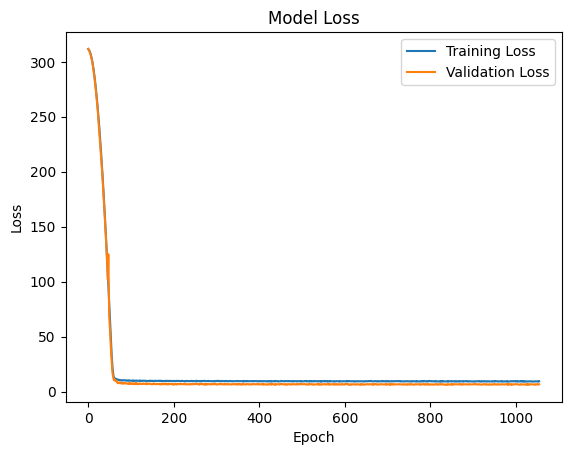

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [11]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicted Solar Energy Ouput: [331.455810546875, 312.71563720703125, 326.165771484375, 329.8599853515625, 320.8385009765625, 298.8011474609375, 306.8857421875, 301.3526611328125, 324.2623291015625, 310.3129577636719, 328.89117431640625, 291.8228759765625, 314.5677490234375, 296.6611328125, 321.61151123046875, 312.12371826171875, 308.0823059082031, 311.39752197265625, 301.75616455078125, 330.8120422363281]
Actual Solar Energy Output: [346. 307. 337. 343. 324. 299. 301. 276. 323. 304. 338. 285. 316. 290.
 327. 309. 307. 311. 298. 343.]


In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 6.754553091498585
Mean Squared Error (MSE): 73.70159738448449
Root Mean Squared Error (RMSE): 8.58496344689274
Percent Error (PERR): 0.02170350261818227


### Save model

In [13]:
model.save('RefuseModel.h5')